In [11]:
%matplotlib inline

In [32]:
from functools import partial
import string

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [28]:
from cue.analysis.analysis import bootstrap_ci
from cue.utils.plotting import *

In [30]:
def ci_l(x, func):
    return bootstrap_ci(x, func)[0]

def ci_u(x, func):
    return bootstrap_ci(x, func)[1]

statistic = lambda func: (func, partial(ci_l, func=func), partial(ci_u, func=func))

In [14]:
style()

# Load data and do some preprocessing

In [53]:
df = pd.DataFrame({k: np.squeeze(v) for k, v in np.load('../../data/decision.npz').iteritems()})

In [54]:
dfd = df.query('decided == True')

# Number clear decisions

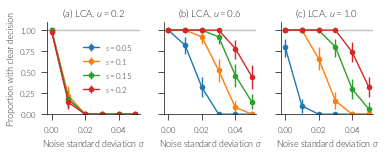

In [55]:
baselines = sorted(df['baseline'].unique())

fig = plt.figure(figsize=(textwidth, row_height))
ax = None
for i, baseline in enumerate(baselines):
    ax = fig.add_subplot(1, len(baselines), i + 1, sharey=ax)    
    ax.axhline(y=1., c=(0.75, 0.75, 0.75))
    for n, g in df.query('network == "LCA" and baseline == {}'.format(baseline)).groupby('target_sep'):
        g_agg = g.groupby('noise').agg(statistic(np.mean))
        m = g_agg['decided', 'mean']
        l = m - g_agg['decided', 'ci_l']
        u = g_agg['decided', 'ci_u'] - m
        ax.errorbar(g_agg.index, m, yerr=[l, u], marker='o', label='$s = {}$'.format(n))
    
    ax.set_title("({}) LCA, $u={}$".format(string.ascii_lowercase[i], baseline))
    ax.set_xlabel(r"Noise standard deviation $\sigma$")
    if i == 0:
        ax.set_ylabel("Proportion with clear decision")
    
    if i == 0:
        ax.legend(loc='center right')
        
for ax in fig.axes:
    ax.label_outer()

ax.set_ylim(0., 1.1)
sns.despine()
fig.tight_layout()

In [56]:
save_tight_fig(fig, '../../../phd-thesis/figures/ia-clear.pdf')

# Correct trials

In [57]:
x = df.query('network == "LCA"')
np.mean(x['correct'] == x['decided'])

1.0

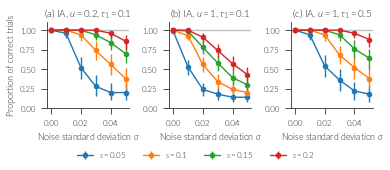

In [58]:
fig = plt.figure(figsize=(textwidth, 1.2 * row_height))
datasets = [
    df.query('network == "IA" and baseline == .2 and scale == 1. and not share_thresholding_intercepts'),
    df.query('network == "IA" and baseline == 1. and scale == 1.'),
    df.query('network == "IA" and baseline == 1. and scale == .2 and not share_thresholding_intercepts'),
]
titles = [
    r"(a) IA, $u = 0.2, \tau_1 = 0.1$",
    r"(b) IA, $u = 1, \tau_1 = 0.1$",
    r"(c) IA, $u = 1, \tau_1 = 0.5$",
]

ax=None
for i, (title, data) in enumerate(zip(titles, datasets)):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    ax.axhline(y=1., c=(0.75, 0.75, 0.75))
    for n, g in data.groupby('target_sep'):
        g_agg = g.groupby('noise').agg(statistic(np.mean))
        m = g_agg['correct', 'mean']
        l = m - g_agg['correct', 'ci_l']
        u = g_agg['correct', 'ci_u'] - m
        ax.errorbar(g_agg.index, m, yerr=[l, u], marker='o', label='$s = {}$'.format(n))
        
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.xlabel(r"Noise standard deviation $\sigma$")

    if i == 0:
        plt.ylabel("Proportion of correct trials")
        
fig.legend(*ax.get_legend_handles_labels(), 
           loc='upper center', bbox_to_anchor=(0.5, 0.25),
            bbox_transform=fig.transFigure, ncol=4)

sns.despine()
plt.tight_layout(rect=(0., 0.2, 1., 1.))

In [59]:
save_tight_fig(fig, '../../../phd-thesis/figures/ia-correct.pdf')

# Decision times

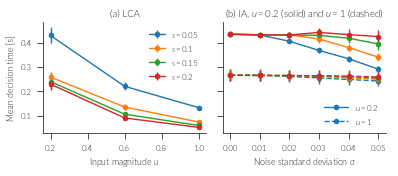

In [65]:
fig = plt.figure(figsize=(textwidth, row_height))
ax = plt.subplot(1, 2, 1)
for n, g in dfd.query('network == "LCA"').groupby('target_sep'):
        g_agg = g.groupby('baseline').agg(statistic(np.mean))
        m = g_agg['t', 'mean']
        l = m - g_agg['t', 'ci_l']
        u = g_agg['t', 'ci_u'] - m
        ax.errorbar(g_agg.index, m, yerr=[l, u], marker='o', label='$s = {}$'.format(n))
ax.set_title("(a) LCA")
ax.set_xlabel("Input magnitude $u$")
ylabel = ax.set_ylabel("Mean decision time [s]")
ax.legend()


ax = plt.subplot(1, 2, 2, sharey=ax)
for n, g in dfd.query('network == "IA" and baseline == 0.2').groupby('target_sep'):
        g_agg = g.groupby('noise').agg(statistic(np.mean))
        m = g_agg['t', 'mean']
        l = m - g_agg['t', 'ci_l']
        u = g_agg['t', 'ci_u'] - m
        ax.errorbar(g_agg.index, m, yerr=[l, u], marker='o', label='$s = {}$'.format(n))
ax.set_prop_cycle(None)
for n, g in dfd.query('network == "IA" and baseline == 1').groupby('target_sep'):
        g_agg = g.groupby('noise').agg(statistic(np.mean))
        m = g_agg['t', 'mean']
        l = m - g_agg['t', 'ci_l']
        u = g_agg['t', 'ci_u'] - m
        ax.errorbar(g_agg.index, m, yerr=[l, u], marker='o', linestyle='--', label='$s = {}$'.format(n))
ax.set_title("(b) IA, $u = 0.2$ (solid) and $u = 1$ (dashed)")
ax.set_xlabel(r"Noise standard deviation $\sigma$")
lines = ax.get_lines()
ax.legend(lines[0::len(lines) // 2], ('$u = 0.2$', '$u = 1$'), loc='lower right', handlelength=3.)

for ax in fig.axes:
    ax.label_outer()

sns.despine(fig)
fig.tight_layout(pad=0.)

In [66]:
save_tight_fig(fig, '../../../phd-thesis/figures/ia-time.pdf')

# Transient response

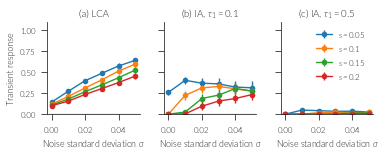

In [70]:
fig = plt.figure(figsize=(textwidth, row_height))

plt.subplot(1, 3, 1)
for n, g in df.query('network == "LCA" and baseline == 1.').groupby('target_sep'):
        g_agg = g.groupby('noise').agg(statistic(np.mean))
        m = g_agg['runnerup_highest_err', 'mean']
        l = m - g_agg['runnerup_highest_err', 'ci_l']
        u = g_agg['runnerup_highest_err', 'ci_u'] - m
        plt.errorbar(g_agg.index, m, yerr=[l, u], marker='o', label='$s = {}$'.format(n))
plt.axhline(y=0., c=(0.75, 0.75, 0.75))
plt.ylim(0, 1.1)
plt.title("(a) LCA")
plt.xlabel(r"Noise standard deviation $\sigma$")
plt.ylabel("Transient response")


plt.subplot(1, 3, 2, sharey=plt.gca())
for n, g in df.query('network == "IA" and scale == 1. and baseline == 1.').groupby('target_sep'):
        g_agg = g.groupby('noise').agg(statistic(np.mean))
        m = g_agg['runnerup_highest_err', 'mean']
        l = m - g_agg['runnerup_highest_err', 'ci_l']
        u = g_agg['runnerup_highest_err', 'ci_u'] - m
        plt.errorbar(g_agg.index, m, yerr=[l, u], marker='o', label='$s = {}$'.format(n))
plt.axhline(y=0., c=(0.75, 0.75, 0.75))
plt.ylim(0, 1.1)
plt.title(r"(b) IA, $\tau_1 = 0.1$")
plt.xlabel(r"Noise standard deviation $\sigma$")

plt.subplot(1, 3, 3, sharey=plt.gca())
for n, g in df.query('network == "IA" and scale == .2 and baseline == 1.').groupby('target_sep'):
        g_agg = g.groupby('noise').agg(statistic(np.mean))
        m = g_agg['runnerup_highest_err', 'mean']
        l = m - g_agg['runnerup_highest_err', 'ci_l']
        u = g_agg['runnerup_highest_err', 'ci_u'] - m
        plt.errorbar(g_agg.index, m, yerr=[l, u], marker='o', label='$s = {}$'.format(n))
plt.axhline(y=0., c=(0.75, 0.75, 0.75))
plt.ylim(0, 1.1)
plt.title(r"(c) IA, $\tau_1 = 0.5$")
plt.xlabel(r"Noise standard deviation $\sigma$")
plt.gca().legend()

for ax in fig.axes:
    ax.label_outer()

sns.despine(fig)
plt.tight_layout()

In [71]:
save_tight_fig(fig, '../../../phd-thesis/figures/ia-transient.pdf')